In [ ]:
import json
import evaluate 
import torch
import pandas as pd
from transformers import T5ForConditionalGeneration, T5Tokenizer, AutoModelForSeq2SeqLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training , TaskType, PeftModel, PeftConfig
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq
)
from datasets import load_dataset, Dataset
from tqdm import tqdm
import re
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

### Модель

In [ ]:
torch.cuda.is_available()

In [45]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [43]:
%tensorboard logdir=results_t5_small_v2

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
usage: tensorboard [-h] [--helpfull] {serve} ...
tensorboard: error: argument {serve}: invalid choice: 'logdir=results_t5_small_v2' (choose from 'serve')

In [14]:
MODEL = 't5-small'
BATCH_SIZE = 16
MAX_LENGTH = 256
EPOCHS = 5
NUM_WORKERS = 8
OUT_DIR = 'results_t5_small_eng'

In [15]:
df = pd.read_json("github-typo-corpus.v1.0.0.jsonl", lines=True)


In [16]:
list_of_incorrect = [x[0]['src']['text'] for x in tqdm(df['edits']) if x[0]['src']['lang'] == 'eng']

100%|██████████████████████████████████████████████████████████████████████| 203270/203270 [00:00<00:00, 887638.79it/s]


In [17]:
list_of_correct = [x[0]['tgt']['text'] for x in tqdm(df['edits'])  if x[0]['src']['lang'] == 'eng']

100%|██████████████████████████████████████████████████████████████████████| 203270/203270 [00:00<00:00, 892734.96it/s]


In [18]:
datset_new = Dataset.from_dict({"original":list_of_incorrect, "corrected":list_of_correct})

In [19]:
datset_new.num_rows

196369

In [20]:
list_of_words_correct = []
for el in list_of_correct:
    list_of_words_correct += re.findall(r'\w+', el)


In [22]:
list_of_words_incorrect = []
for el in list_of_incorrect:
    list_of_words_incorrect += re.findall(r'\w+', el)

In [23]:
has_in_correct = set(list_of_words_correct) - set(list_of_words_incorrect)
has_in_incorrect = set(list_of_words_incorrect) - set(list_of_words_correct)

In [24]:
cleared_list_of_words_correct = " ".join([el for el in list_of_words_correct if el in has_in_correct])
cleared_list_of_words_incorrect = " ".join([el for el in list_of_words_incorrect if el in has_in_incorrect])

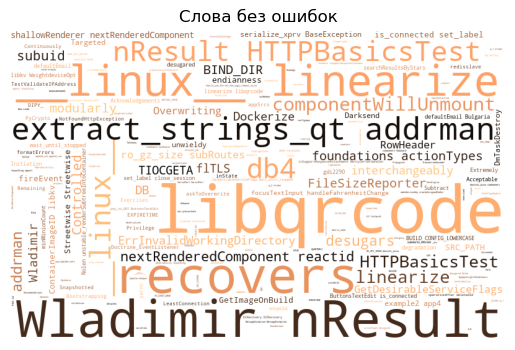

In [25]:
wc = WordCloud(background_color='white', colormap = 'copper', width = 800, height = 500).\
    generate(cleared_list_of_words_correct)
plt.axis("off")
plt.imshow(wc)
plt.title("Слова без ошибок");
plt.savefig('correct.png', bbox_inches='tight')

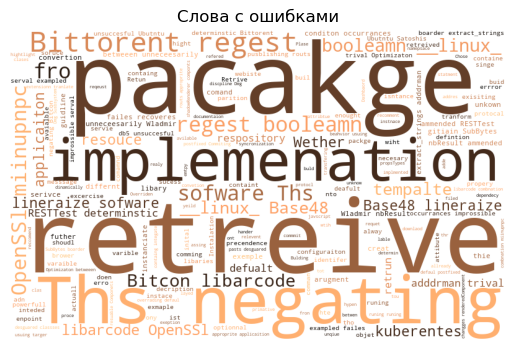

In [26]:
wc = WordCloud(background_color='white', colormap = 'copper', width = 800, height = 500).\
    generate(cleared_list_of_words_incorrect)
plt.axis("off")
plt.imshow(wc)
plt.title("Слова с ошибками");
plt.savefig('incorrect.png', bbox_inches='tight')

In [27]:
train_dataset, validation_test_dataset = datset_new.train_test_split(test_size=0.4).values()
validation_dataset, test_dataset = validation_test_dataset.train_test_split(test_size=0.5).values()

In [28]:
train_dataset.num_rows, validation_dataset.num_rows, test_dataset.num_rows

(117821, 39274, 39274)

In [29]:
tokenizer = T5Tokenizer.from_pretrained(MODEL)


C:\Users\victo\.conda\envs\ML_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [30]:
# Function to convert text data into model inputs and targets

def preprocess_function(examples):
    inputs = [f"grammar: {inc}" for inc in examples['original']]#This will help in improving the performance, as this task prefix was used during T5’s pre-training.
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_LENGTH,
        truncation=True,
        padding='max_length'
    )

    labels = tokenizer(
      text_target = examples['corrected'],
      max_length=MAX_LENGTH,
      truncation=True,
      padding='max_length')

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
# Apply the function to the whole dataset
tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True
)
tokenized_valid = validation_dataset.map(
    preprocess_function,
    batched=True
)
tokenized_test = test_dataset.map(
    preprocess_function,
    batched=True
)

Map:   0%|          | 0/117821 [00:00<?, ? examples/s]

Map:   0%|          | 0/39274 [00:00<?, ? examples/s]

Map:   0%|          | 0/39274 [00:00<?, ? examples/s]

In [37]:
# Specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
# Load the pre-trained BART model
model = T5ForConditionalGeneration.from_pretrained(MODEL, torchscript=True)

# model.to(device)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at t5-small and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


76,956,160 total parameters.
76,956,160 training parameters.


In [35]:
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [59]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/model_graph_t5_peft')

In [60]:
dataiter = next(iter(tokenized_train))

In [61]:
writer.add_graph(model, (torch.tensor([dataiter['input_ids']]), torch.tensor([dataiter['attention_mask']]), torch.Tensor([[2]]).long()), 
                 False, use_strict_trace=False)
writer.flush()
writer.close();

In [32]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training , TaskType
 
# Define LoRA Config
lora_config = LoraConfig(
 r=16,
 lora_alpha=32,
 target_modules=["q", "k", "v", "o"],
 lora_dropout=0.05,
 bias="none",
 task_type=TaskType.SEQ_2_SEQ_LM
)
# prepare int-8 model for training
model = prepare_model_for_kbit_training(model) # Using the prepare_model_for_kbit_training method from PEFT
 
# add LoRA adaptor
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 1,179,648 || all params: 78,135,808 || trainable%: 1.5097


### Обучение

In [79]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir=OUT_DIR,          
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE*2,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir=OUT_DIR,
    evaluation_strategy='steps',
    save_steps=500,
    eval_steps=500,
    logging_steps = 500,
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to='tensorboard',
    overwrite_output_dir = True,
    save_safetensors = False,
    dataloader_num_workers=4
)

In [80]:
torch.cuda.empty_cache()
model.to(device);

In [82]:
# Create the Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid)
# Start training
history = trainer.train()

Step,Training Loss,Validation Loss
500,1.090700,0.169264
1000,0.153100,0.108767
1500,0.100600,0.067598
2000,0.076500,0.060171
2500,0.069300,0.056929
3000,0.067000,0.054949
3500,0.063100,0.053543
4000,0.060800,0.052067
4500,0.060000,0.050962
5000,0.057700,0.050328


C:\Users\victo\.conda\envs\ML_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\victo\.conda\envs\ML_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\victo\.conda\envs\ML_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\victo\.conda\envs\ML_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resum

In [83]:
tokenizer.save_pretrained('final_model_t5_small_eng')
model.save_pretrained('final_model_t5_small_eng')

C:\Users\victo\.conda\envs\ML_env\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [84]:
trainer.evaluate(tokenized_test)

{'eval_loss': 0.04305696487426758,
 'eval_runtime': 304.9761,
 'eval_samples_per_second': 128.777,
 'eval_steps_per_second': 4.027,
 'epoch': 5.0}

### Тестирование

In [33]:

 
# Load peft config for pre-trained checkpoint etc.
peft_model_id = "final_model_t5_small_eng"
config = PeftConfig.from_pretrained(peft_model_id)
 
# load base LLM model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained(config.base_model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
 
# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)
model = model.merge_and_unload()
model.eval()
 

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [34]:
def do_correction(text, model, tokenizer):
    input_text = f"grammar: {text}"
    inputs = tokenizer.encode(
        input_text,
        return_tensors='pt',
        max_length=256,
        padding='max_length',
        truncation=True
    )
    # Get correct sentence ids.
    corrected_ids = model.generate(
        inputs,
        max_length=384,
        num_beams=5,
        early_stopping=True
    )
    # Decode.
    corrected_sentence = tokenizer.decode(
        corrected_ids[0],
        skip_special_tokens=True
    )
    return corrected_sentence

In [35]:
sentences = [
    "My name iss Victor."
]
for sentence in sentences:
    corrected_sentence = do_correction(sentence, model, tokenizer)
    print(f"ORIG: {sentence}\nCORRECT: {corrected_sentence}")

ORIG: My name iss Victor.
CORRECT: My name is Victor.


In [38]:
device

device(type='cuda')

In [39]:
torch.cuda.empty_cache()
model.to(device);

In [41]:
glue_score = []
bleu = evaluate.load("google_bleu")

for index_example, input_example in enumerate(tqdm(tokenized_test)):
    input_ids = torch.tensor([input_example['input_ids']]).to(device)
    attention_mask = torch.tensor([input_example['attention_mask']]).to(device)
    
    outputs = model.generate(input_ids= input_ids,
                         attention_mask=attention_mask,max_length=384)
  
    predicted_answer = tokenizer.decode(outputs.flatten(), skip_special_tokens=True)
    # print(predicted_answer.strip())
    # print([input_example['corrected'].strip()])
    
    score = bleu.compute(predictions= [predicted_answer.strip()], references=[input_example['corrected'].strip()])
    glue_score.append(score['google_bleu'])
    if index_example and (index_example % 100 == 0):
        print(f"index: {index_example}, mean result {np.mean(glue_score)}")


  0%|▏                                                                           | 101/39274 [00:40<4:23:02,  2.48it/s]

index: 100, mean result 0.735454240810834


  1%|▍                                                                           | 201/39274 [01:23<8:42:43,  1.25it/s]

index: 200, mean result 0.7185693947343673


  1%|▌                                                                           | 301/39274 [02:01<3:34:52,  3.02it/s]

index: 300, mean result 0.7283202566780691


  1%|▊                                                                           | 401/39274 [02:37<3:06:31,  3.47it/s]

index: 400, mean result 0.7176827896419637


  1%|▉                                                                           | 501/39274 [03:15<3:10:43,  3.39it/s]

index: 500, mean result 0.7155478873508948


  2%|█▏                                                                          | 601/39274 [04:01<5:32:20,  1.94it/s]

index: 600, mean result 0.714590453317992


  2%|█▎                                                                          | 701/39274 [04:43<4:28:13,  2.40it/s]

index: 700, mean result 0.7158873451720019


  2%|█▌                                                                          | 801/39274 [05:21<3:44:30,  2.86it/s]

index: 800, mean result 0.7186403299864499


  2%|█▋                                                                          | 901/39274 [06:06<3:03:45,  3.48it/s]

index: 900, mean result 0.7178144059906834


  3%|█▉                                                                         | 1001/39274 [06:53<5:56:53,  1.79it/s]

index: 1000, mean result 0.719026179682808


  3%|██                                                                         | 1101/39274 [07:36<3:44:58,  2.83it/s]

index: 1100, mean result 0.7201364586987142


  3%|██▎                                                                        | 1201/39274 [08:22<4:30:54,  2.34it/s]

index: 1200, mean result 0.7209060257044775


  3%|██▍                                                                        | 1301/39274 [09:03<3:56:58,  2.67it/s]

index: 1300, mean result 0.7207165688446455


  4%|██▋                                                                        | 1401/39274 [09:46<2:21:43,  4.45it/s]

index: 1400, mean result 0.7202128385734685


  4%|██▊                                                                        | 1501/39274 [10:28<4:11:52,  2.50it/s]

index: 1500, mean result 0.7196361802432931


  4%|███                                                                        | 1601/39274 [11:08<4:45:55,  2.20it/s]

index: 1600, mean result 0.7180664578540585


  4%|███▏                                                                       | 1701/39274 [11:49<3:55:36,  2.66it/s]

index: 1700, mean result 0.7176594241133495


  5%|███▍                                                                       | 1801/39274 [12:31<2:45:08,  3.78it/s]

index: 1800, mean result 0.7184628558821


  5%|███▋                                                                       | 1901/39274 [13:24<4:53:05,  2.13it/s]

index: 1900, mean result 0.7188630219571283


  5%|███▊                                                                       | 2001/39274 [14:12<2:41:51,  3.84it/s]

index: 2000, mean result 0.7182223663302587


  5%|████                                                                       | 2101/39274 [14:51<3:19:13,  3.11it/s]

index: 2100, mean result 0.7191978416334632


  6%|████▏                                                                      | 2201/39274 [15:35<5:53:44,  1.75it/s]

index: 2200, mean result 0.7198785661732808


  6%|████▍                                                                      | 2302/39274 [16:22<3:23:06,  3.03it/s]

index: 2300, mean result 0.721064492209069


  6%|████▌                                                                      | 2401/39274 [17:07<4:04:26,  2.51it/s]

index: 2400, mean result 0.7201023514932016


  6%|████▊                                                                      | 2501/39274 [17:52<4:00:35,  2.55it/s]

index: 2500, mean result 0.7194297109635105


  7%|████▉                                                                      | 2601/39274 [18:31<6:39:18,  1.53it/s]

index: 2600, mean result 0.7190220980909873


  7%|█████▏                                                                     | 2701/39274 [19:15<3:26:29,  2.95it/s]

index: 2700, mean result 0.7193610525372476


  7%|█████▎                                                                     | 2801/39274 [19:56<3:06:33,  3.26it/s]

index: 2800, mean result 0.7189937770719693


  7%|█████▌                                                                     | 2901/39274 [20:37<3:28:11,  2.91it/s]

index: 2900, mean result 0.7184206956553383


  8%|█████▋                                                                     | 3002/39274 [21:26<5:47:58,  1.74it/s]

index: 3000, mean result 0.719232537505086


  8%|█████▉                                                                     | 3101/39274 [22:06<2:57:23,  3.40it/s]

index: 3100, mean result 0.7190063077309956


  8%|██████                                                                     | 3201/39274 [22:54<3:18:17,  3.03it/s]

index: 3200, mean result 0.7185355697351277


  8%|██████▎                                                                    | 3301/39274 [23:44<2:32:34,  3.93it/s]

index: 3300, mean result 0.7168923844573502


  9%|██████▍                                                                    | 3402/39274 [24:30<5:17:55,  1.88it/s]

index: 3400, mean result 0.7175232306245296


  9%|██████▋                                                                    | 3502/39274 [25:08<3:06:27,  3.20it/s]

index: 3500, mean result 0.7163923166225102


  9%|██████▉                                                                    | 3602/39274 [25:55<4:40:49,  2.12it/s]

index: 3600, mean result 0.7156589336918885


  9%|███████                                                                    | 3702/39274 [26:40<2:40:49,  3.69it/s]

index: 3700, mean result 0.7148997877066746


 10%|███████▎                                                                   | 3801/39274 [27:22<3:44:02,  2.64it/s]

index: 3800, mean result 0.7137896233090197


 10%|███████▍                                                                   | 3901/39274 [28:07<3:39:32,  2.69it/s]

index: 3900, mean result 0.7148716239019159


 10%|███████▋                                                                   | 4000/39274 [28:45<2:17:06,  4.29it/s]

index: 4000, mean result 0.7147665677270063


 10%|███████▊                                                                   | 4101/39274 [29:31<3:52:04,  2.53it/s]

index: 4100, mean result 0.7142447702827084


 11%|████████                                                                   | 4201/39274 [30:20<3:44:09,  2.61it/s]

index: 4200, mean result 0.714927908039296


 11%|████████▏                                                                  | 4301/39274 [30:59<5:22:41,  1.81it/s]

index: 4300, mean result 0.7146305313229206


 11%|████████▍                                                                  | 4401/39274 [31:46<6:50:34,  1.42it/s]

index: 4400, mean result 0.7151408119328001


 11%|████████▌                                                                  | 4502/39274 [32:29<3:25:01,  2.83it/s]

index: 4500, mean result 0.7145480317477954


 12%|████████▊                                                                  | 4601/39274 [33:17<5:32:53,  1.74it/s]

index: 4600, mean result 0.7151440851647808


 12%|████████▉                                                                  | 4700/39274 [33:56<3:26:02,  2.80it/s]

index: 4700, mean result 0.7150483660009316


 12%|█████████▏                                                                 | 4801/39274 [34:43<5:58:42,  1.60it/s]

index: 4800, mean result 0.715262819008717


 12%|█████████▎                                                                 | 4901/39274 [35:27<3:04:46,  3.10it/s]

index: 4900, mean result 0.7149636527032545


 13%|█████████▌                                                                 | 5001/39274 [36:11<4:11:17,  2.27it/s]

index: 5000, mean result 0.7155109880694043


 13%|█████████▋                                                                 | 5101/39274 [36:58<2:47:32,  3.40it/s]

index: 5100, mean result 0.7157060607332923


 13%|█████████▉                                                                 | 5201/39274 [37:41<3:38:47,  2.60it/s]

index: 5200, mean result 0.7148803229299824


 13%|██████████                                                                 | 5301/39274 [38:20<2:42:23,  3.49it/s]

index: 5300, mean result 0.7148509161210322


 14%|██████████▎                                                                | 5401/39274 [39:02<3:31:58,  2.66it/s]

index: 5400, mean result 0.7154880363093973


 14%|██████████▌                                                                | 5502/39274 [39:47<2:41:26,  3.49it/s]

index: 5500, mean result 0.715084558557442


 14%|██████████▋                                                                | 5601/39274 [40:30<5:14:53,  1.78it/s]

index: 5600, mean result 0.7160064937623054


 15%|██████████▉                                                                | 5701/39274 [41:10<8:35:00,  1.09it/s]

index: 5700, mean result 0.7167162304988598


 15%|███████████                                                                | 5801/39274 [41:54<4:30:31,  2.06it/s]

index: 5800, mean result 0.7160993942157254


 15%|███████████▎                                                               | 5901/39274 [42:29<1:58:55,  4.68it/s]

index: 5900, mean result 0.7159020536325668


 15%|███████████▍                                                               | 6001/39274 [43:05<2:37:15,  3.53it/s]

index: 6000, mean result 0.7150449151925857


 16%|███████████▋                                                               | 6101/39274 [43:45<4:50:57,  1.90it/s]

index: 6100, mean result 0.7148415765743932


 16%|███████████▊                                                               | 6202/39274 [44:25<2:51:36,  3.21it/s]

index: 6200, mean result 0.7146921206852689


 16%|████████████                                                               | 6300/39274 [45:02<3:58:13,  2.31it/s]

index: 6300, mean result 0.7143540976947329


 16%|████████████▏                                                              | 6401/39274 [45:37<2:38:34,  3.45it/s]

index: 6400, mean result 0.7144029234838419


 17%|████████████▍                                                              | 6501/39274 [46:25<2:19:12,  3.92it/s]

index: 6500, mean result 0.7136387621014679


 17%|████████████▌                                                              | 6601/39274 [47:02<2:22:54,  3.81it/s]

index: 6600, mean result 0.7135216187539251


 17%|████████████▊                                                              | 6701/39274 [47:44<3:07:53,  2.89it/s]

index: 6700, mean result 0.7134730537734723


 17%|████████████▉                                                              | 6802/39274 [48:27<3:35:11,  2.51it/s]

index: 6800, mean result 0.7133901679457296


 18%|█████████████▏                                                             | 6901/39274 [49:05<5:11:56,  1.73it/s]

index: 6900, mean result 0.7128792855578091


 18%|█████████████▎                                                             | 7001/39274 [49:47<2:57:34,  3.03it/s]

index: 7000, mean result 0.7131366823933822


 18%|█████████████▌                                                             | 7101/39274 [50:25<4:19:43,  2.06it/s]

index: 7100, mean result 0.7135860374236566


 18%|█████████████▊                                                             | 7201/39274 [51:08<6:23:41,  1.39it/s]

index: 7200, mean result 0.7134310218062933


 19%|█████████████▉                                                             | 7301/39274 [51:51<2:48:20,  3.17it/s]

index: 7300, mean result 0.713482219988149


 19%|██████████████▏                                                            | 7402/39274 [52:30<3:14:57,  2.72it/s]

index: 7400, mean result 0.7135234438168773


 19%|██████████████▎                                                            | 7501/39274 [53:08<2:52:36,  3.07it/s]

index: 7500, mean result 0.7134475813252166


 19%|██████████████▌                                                            | 7601/39274 [53:49<4:02:53,  2.17it/s]

index: 7600, mean result 0.7130497630820594


 20%|██████████████▋                                                            | 7701/39274 [54:26<2:43:13,  3.22it/s]

index: 7700, mean result 0.7132337150498002


 20%|██████████████▉                                                            | 7801/39274 [55:09<3:57:19,  2.21it/s]

index: 7800, mean result 0.7132094377143688


 20%|███████████████                                                            | 7901/39274 [55:50<2:36:33,  3.34it/s]

index: 7900, mean result 0.7128601310974302


 20%|███████████████▎                                                           | 8001/39274 [56:30<2:35:22,  3.35it/s]

index: 8000, mean result 0.7125836582268928


 21%|███████████████▍                                                           | 8100/39274 [57:10<3:50:10,  2.26it/s]

index: 8100, mean result 0.7128756279710615


 21%|███████████████▋                                                           | 8201/39274 [57:52<3:13:46,  2.67it/s]

index: 8200, mean result 0.7128357951460297


 21%|███████████████▊                                                           | 8301/39274 [58:31<3:20:09,  2.58it/s]

index: 8300, mean result 0.7125030165050997


 21%|████████████████                                                           | 8402/39274 [59:14<2:17:48,  3.73it/s]

index: 8400, mean result 0.7125687134809475


 22%|████████████████▏                                                          | 8500/39274 [59:51<2:46:54,  3.07it/s]

index: 8500, mean result 0.7125109722501484


 22%|███████████████▉                                                         | 8602/39274 [1:00:36<5:04:19,  1.68it/s]

index: 8600, mean result 0.7123008493512826


 22%|████████████████▏                                                        | 8701/39274 [1:01:12<5:48:51,  1.46it/s]

index: 8700, mean result 0.7121109484631316


 22%|████████████████▎                                                        | 8801/39274 [1:01:55<3:05:32,  2.74it/s]

index: 8800, mean result 0.7126119732910987


 23%|████████████████▌                                                        | 8902/39274 [1:02:38<2:24:41,  3.50it/s]

index: 8900, mean result 0.7127045493491094


 23%|████████████████▋                                                        | 9001/39274 [1:03:11<2:11:45,  3.83it/s]

index: 9000, mean result 0.7127783490054144


 23%|████████████████▉                                                        | 9101/39274 [1:03:54<4:54:22,  1.71it/s]

index: 9100, mean result 0.7124764203129185


 23%|█████████████████                                                        | 9201/39274 [1:04:33<3:28:09,  2.41it/s]

index: 9200, mean result 0.7124081310282762


 24%|█████████████████▎                                                       | 9301/39274 [1:05:15<6:06:35,  1.36it/s]

index: 9300, mean result 0.7125358498406235


 24%|█████████████████▍                                                       | 9401/39274 [1:06:04<3:37:44,  2.29it/s]

index: 9400, mean result 0.712688247419439


 24%|█████████████████▋                                                       | 9501/39274 [1:06:41<2:32:56,  3.24it/s]

index: 9500, mean result 0.712930645654962


 24%|█████████████████▊                                                       | 9601/39274 [1:07:26<2:36:47,  3.15it/s]

index: 9600, mean result 0.713010513092505


 25%|██████████████████                                                       | 9701/39274 [1:08:09<2:30:08,  3.28it/s]

index: 9700, mean result 0.7128573404297172


 25%|██████████████████▏                                                      | 9801/39274 [1:08:50<4:28:48,  1.83it/s]

index: 9800, mean result 0.7125932009680279


 25%|██████████████████▍                                                      | 9901/39274 [1:09:32<2:17:53,  3.55it/s]

index: 9900, mean result 0.7130151610982701


 25%|██████████████████▎                                                     | 10002/39274 [1:10:10<3:30:45,  2.31it/s]

index: 10000, mean result 0.7129029097838868


 26%|██████████████████▌                                                     | 10101/39274 [1:10:50<2:23:38,  3.38it/s]

index: 10100, mean result 0.7129394307719998


 26%|██████████████████▋                                                     | 10202/39274 [1:11:33<1:39:23,  4.87it/s]

index: 10200, mean result 0.7132199692047333


 26%|██████████████████▉                                                     | 10301/39274 [1:12:13<3:08:21,  2.56it/s]

index: 10300, mean result 0.7129800753514685


 26%|███████████████████                                                     | 10401/39274 [1:12:55<1:51:57,  4.30it/s]

index: 10400, mean result 0.7126648147016996


 27%|███████████████████▎                                                    | 10501/39274 [1:13:36<2:22:03,  3.38it/s]

index: 10500, mean result 0.7130096493018878


 27%|███████████████████▍                                                    | 10602/39274 [1:14:19<2:13:51,  3.57it/s]

index: 10600, mean result 0.7131270900566528


 27%|███████████████████▌                                                    | 10701/39274 [1:15:06<3:45:59,  2.11it/s]

index: 10700, mean result 0.7130381845593983


 28%|███████████████████▊                                                    | 10801/39274 [1:15:44<3:06:21,  2.55it/s]

index: 10800, mean result 0.713320692068517


 28%|███████████████████▉                                                    | 10901/39274 [1:16:23<2:22:54,  3.31it/s]

index: 10900, mean result 0.7134014700105341


 28%|████████████████████▏                                                   | 11001/39274 [1:17:02<2:12:41,  3.55it/s]

index: 11000, mean result 0.7133220112074325


 28%|████████████████████▎                                                   | 11101/39274 [1:17:44<5:46:19,  1.36it/s]

index: 11100, mean result 0.713393835455688


 29%|████████████████████▌                                                   | 11201/39274 [1:18:26<2:52:21,  2.71it/s]

index: 11200, mean result 0.7133726268452647


 29%|████████████████████▋                                                   | 11301/39274 [1:19:05<2:46:47,  2.80it/s]

index: 11300, mean result 0.7132517089743096


 29%|████████████████████▉                                                   | 11401/39274 [1:19:44<1:54:34,  4.05it/s]

index: 11400, mean result 0.7133278453940815


 29%|█████████████████████                                                   | 11501/39274 [1:20:26<5:20:51,  1.44it/s]

index: 11500, mean result 0.7133707591492723


 30%|█████████████████████▎                                                  | 11601/39274 [1:21:01<4:42:44,  1.63it/s]

index: 11600, mean result 0.7134220283080132


 30%|█████████████████████▍                                                  | 11701/39274 [1:21:43<2:28:21,  3.10it/s]

index: 11700, mean result 0.7130346844133707


 30%|█████████████████████▋                                                  | 11801/39274 [1:22:20<1:35:24,  4.80it/s]

index: 11800, mean result 0.7130036894489317


 30%|█████████████████████▊                                                  | 11901/39274 [1:23:01<3:44:57,  2.03it/s]

index: 11900, mean result 0.7131252034219326


 31%|██████████████████████                                                  | 12001/39274 [1:23:40<4:37:01,  1.64it/s]

index: 12000, mean result 0.712964417503448


 31%|██████████████████████▏                                                 | 12101/39274 [1:24:18<3:10:09,  2.38it/s]

index: 12100, mean result 0.7132127573393597


 31%|██████████████████████▎                                                 | 12201/39274 [1:25:01<3:41:35,  2.04it/s]

index: 12200, mean result 0.7133622881925803


 31%|██████████████████████▌                                                 | 12300/39274 [1:25:44<2:55:54,  2.56it/s]

index: 12300, mean result 0.7134964462051058


 32%|██████████████████████▋                                                 | 12401/39274 [1:26:25<2:14:19,  3.33it/s]

index: 12400, mean result 0.713765431722274


 32%|██████████████████████▉                                                 | 12501/39274 [1:27:06<2:11:38,  3.39it/s]

index: 12500, mean result 0.7136401705801976


 32%|███████████████████████                                                 | 12601/39274 [1:27:44<2:56:12,  2.52it/s]

index: 12600, mean result 0.713596326542477


 32%|███████████████████████▎                                                | 12702/39274 [1:28:21<3:42:52,  1.99it/s]

index: 12700, mean result 0.7134542965636895


 33%|███████████████████████▍                                                | 12802/39274 [1:29:04<1:28:57,  4.96it/s]

index: 12800, mean result 0.7136822038198095


 33%|███████████████████████▋                                                | 12902/39274 [1:29:53<1:45:55,  4.15it/s]

index: 12900, mean result 0.7136559995406229


 33%|███████████████████████▊                                                | 13002/39274 [1:30:36<1:42:40,  4.26it/s]

index: 13000, mean result 0.7134557986669946


 33%|████████████████████████                                                | 13101/39274 [1:31:14<1:56:17,  3.75it/s]

index: 13100, mean result 0.7133197451121254


 34%|████████████████████████▏                                               | 13201/39274 [1:31:53<2:30:24,  2.89it/s]

index: 13200, mean result 0.713273807537585


 34%|████████████████████████▍                                               | 13301/39274 [1:32:36<2:36:19,  2.77it/s]

index: 13300, mean result 0.7132339856415524


 34%|████████████████████████▌                                               | 13401/39274 [1:33:15<2:16:20,  3.16it/s]

index: 13400, mean result 0.713249936905612


 34%|████████████████████████▊                                               | 13501/39274 [1:33:57<3:19:33,  2.15it/s]

index: 13500, mean result 0.713108460526953


 35%|████████████████████████▉                                               | 13601/39274 [1:34:38<4:02:24,  1.77it/s]

index: 13600, mean result 0.7133302809348935


 35%|█████████████████████████                                               | 13701/39274 [1:35:19<3:46:10,  1.88it/s]

index: 13700, mean result 0.7134870804739649


 35%|█████████████████████████▎                                              | 13801/39274 [1:35:58<3:34:36,  1.98it/s]

index: 13800, mean result 0.7131963281067473


 35%|█████████████████████████▍                                              | 13902/39274 [1:36:37<1:35:24,  4.43it/s]

index: 13900, mean result 0.7130571726451553


 36%|█████████████████████████▋                                              | 14001/39274 [1:37:15<3:39:33,  1.92it/s]

index: 14000, mean result 0.713131674439377


 36%|█████████████████████████▊                                              | 14101/39274 [1:37:57<1:28:45,  4.73it/s]

index: 14100, mean result 0.713368585978277


 36%|██████████████████████████                                              | 14202/39274 [1:38:39<2:39:10,  2.63it/s]

index: 14200, mean result 0.7133647633232002


 36%|██████████████████████████▏                                             | 14301/39274 [1:39:19<3:25:56,  2.02it/s]

index: 14300, mean result 0.713285411783553


 37%|██████████████████████████▍                                             | 14402/39274 [1:39:58<1:37:35,  4.25it/s]

index: 14400, mean result 0.7134955049049474


 37%|██████████████████████████▌                                             | 14501/39274 [1:40:37<3:25:03,  2.01it/s]

index: 14500, mean result 0.7135075796887262


 37%|██████████████████████████▊                                             | 14601/39274 [1:41:17<2:05:58,  3.26it/s]

index: 14600, mean result 0.7132763779405278


 37%|██████████████████████████▉                                             | 14701/39274 [1:42:00<3:43:42,  1.83it/s]

index: 14700, mean result 0.7132254395348931


 38%|███████████████████████████▏                                            | 14801/39274 [1:42:39<2:26:19,  2.79it/s]

index: 14800, mean result 0.71304848686642


 38%|███████████████████████████▎                                            | 14901/39274 [1:43:14<1:40:23,  4.05it/s]

index: 14900, mean result 0.7129209767607032


 38%|███████████████████████████▌                                            | 15001/39274 [1:43:54<4:24:50,  1.53it/s]

index: 15000, mean result 0.7130028822382517


 38%|███████████████████████████▋                                            | 15101/39274 [1:44:39<5:09:09,  1.30it/s]

index: 15100, mean result 0.7129168578538818


 39%|███████████████████████████▊                                            | 15201/39274 [1:45:22<2:21:13,  2.84it/s]

index: 15200, mean result 0.7131563540017605


 39%|████████████████████████████                                            | 15301/39274 [1:46:02<1:46:27,  3.75it/s]

index: 15300, mean result 0.7129796316814064


 39%|████████████████████████████▏                                           | 15401/39274 [1:46:41<1:49:27,  3.64it/s]

index: 15400, mean result 0.7129335001998961


 39%|████████████████████████████▍                                           | 15501/39274 [1:47:17<1:49:02,  3.63it/s]

index: 15500, mean result 0.7129439901778448


 40%|████████████████████████████▌                                           | 15602/39274 [1:48:05<3:16:22,  2.01it/s]

index: 15600, mean result 0.7132992997197884


 40%|████████████████████████████▊                                           | 15701/39274 [1:48:43<2:56:36,  2.22it/s]

index: 15700, mean result 0.7130915395425894


 40%|████████████████████████████▉                                           | 15801/39274 [1:49:21<1:16:57,  5.08it/s]

index: 15800, mean result 0.7129675568140502


 40%|█████████████████████████████▏                                          | 15902/39274 [1:50:04<2:31:58,  2.56it/s]

index: 15900, mean result 0.7127441937820435


 41%|█████████████████████████████▎                                          | 16001/39274 [1:50:44<4:05:09,  1.58it/s]

index: 16000, mean result 0.7126463209153554


 41%|█████████████████████████████▌                                          | 16101/39274 [1:51:21<2:02:26,  3.15it/s]

index: 16100, mean result 0.7128909900451226


 41%|█████████████████████████████▋                                          | 16201/39274 [1:52:01<1:56:35,  3.30it/s]

index: 16200, mean result 0.712842911052197


 42%|█████████████████████████████▉                                          | 16301/39274 [1:52:38<2:02:12,  3.13it/s]

index: 16300, mean result 0.7126755996757823


 42%|██████████████████████████████                                          | 16402/39274 [1:53:23<4:36:39,  1.38it/s]

index: 16400, mean result 0.7125991153551604


 42%|██████████████████████████████▎                                         | 16501/39274 [1:54:09<2:44:56,  2.30it/s]

index: 16500, mean result 0.7124493150304612


 42%|██████████████████████████████▍                                         | 16602/39274 [1:54:53<1:36:18,  3.92it/s]

index: 16600, mean result 0.7125143869189284


 43%|██████████████████████████████▌                                         | 16701/39274 [1:55:32<3:00:26,  2.08it/s]

index: 16700, mean result 0.7124290705838464


 43%|██████████████████████████████▊                                         | 16801/39274 [1:56:11<2:13:11,  2.81it/s]

index: 16800, mean result 0.7124700850995923


 43%|██████████████████████████████▉                                         | 16901/39274 [1:56:48<3:21:22,  1.85it/s]

index: 16900, mean result 0.7123553389755483


 43%|███████████████████████████████▏                                        | 17001/39274 [1:57:24<1:58:48,  3.12it/s]

index: 17000, mean result 0.7122822316276447


 44%|███████████████████████████████▎                                        | 17101/39274 [1:58:01<3:14:26,  1.90it/s]

index: 17100, mean result 0.7122458035200246


 44%|███████████████████████████████▌                                        | 17201/39274 [1:58:37<1:16:21,  4.82it/s]

index: 17200, mean result 0.7121512145543542


 44%|███████████████████████████████▋                                        | 17301/39274 [1:59:23<4:40:44,  1.30it/s]

index: 17300, mean result 0.7123019523200923


 44%|███████████████████████████████▉                                        | 17401/39274 [2:00:01<2:30:31,  2.42it/s]

index: 17400, mean result 0.7123265782777354


 45%|████████████████████████████████                                        | 17502/39274 [2:00:41<1:49:07,  3.33it/s]

index: 17500, mean result 0.7125438694457507


 45%|████████████████████████████████▎                                       | 17601/39274 [2:01:20<2:32:51,  2.36it/s]

index: 17600, mean result 0.7124575370202461


 45%|████████████████████████████████▍                                       | 17700/39274 [2:01:56<1:58:29,  3.03it/s]

index: 17700, mean result 0.7125091073177877


 45%|████████████████████████████████▋                                       | 17802/39274 [2:02:34<1:49:16,  3.28it/s]

index: 17800, mean result 0.7124361204409757


 46%|████████████████████████████████▊                                       | 17901/39274 [2:03:09<1:53:04,  3.15it/s]

index: 17900, mean result 0.7126226168585473


 46%|█████████████████████████████████                                       | 18001/39274 [2:03:47<2:38:06,  2.24it/s]

index: 18000, mean result 0.7126647909607087


 46%|█████████████████████████████████▏                                      | 18101/39274 [2:04:25<2:59:44,  1.96it/s]

index: 18100, mean result 0.7126537964310942


 46%|█████████████████████████████████▎                                      | 18202/39274 [2:05:05<1:28:24,  3.97it/s]

index: 18200, mean result 0.7123811899053725


 47%|█████████████████████████████████▌                                      | 18301/39274 [2:05:41<1:24:31,  4.14it/s]

index: 18300, mean result 0.7123664214607786


 47%|█████████████████████████████████▋                                      | 18401/39274 [2:06:23<2:50:44,  2.04it/s]

index: 18400, mean result 0.7124740297628782


 47%|█████████████████████████████████▉                                      | 18502/39274 [2:06:59<2:19:47,  2.48it/s]

index: 18500, mean result 0.7122465114847939


 47%|██████████████████████████████████                                      | 18601/39274 [2:07:40<2:34:57,  2.22it/s]

index: 18600, mean result 0.7123172709600495


 48%|██████████████████████████████████▎                                     | 18701/39274 [2:08:19<4:00:10,  1.43it/s]

index: 18700, mean result 0.7123010041832587


 48%|██████████████████████████████████▍                                     | 18801/39274 [2:08:53<1:56:41,  2.92it/s]

index: 18800, mean result 0.7122277490466492


 48%|██████████████████████████████████▋                                     | 18902/39274 [2:09:29<1:52:57,  3.01it/s]

index: 18900, mean result 0.7119779982529649


 48%|██████████████████████████████████▊                                     | 19001/39274 [2:10:07<1:41:39,  3.32it/s]

index: 19000, mean result 0.7120886465665209


 49%|███████████████████████████████████                                     | 19101/39274 [2:10:42<2:19:10,  2.42it/s]

index: 19100, mean result 0.7119698428030798


 49%|███████████████████████████████████▏                                    | 19201/39274 [2:11:23<2:12:28,  2.53it/s]

index: 19200, mean result 0.7119272690890823


 49%|███████████████████████████████████▍                                    | 19301/39274 [2:12:01<2:56:33,  1.89it/s]

index: 19300, mean result 0.7119529176585334


 49%|███████████████████████████████████▌                                    | 19401/39274 [2:12:39<2:03:06,  2.69it/s]

index: 19400, mean result 0.7119939752623013


 50%|███████████████████████████████████▊                                    | 19501/39274 [2:13:23<1:53:08,  2.91it/s]

index: 19500, mean result 0.712077483961983


 50%|███████████████████████████████████▉                                    | 19572/39274 [2:13:55<2:14:48,  2.44it/s]


KeyboardInterrupt: 

In [163]:
np.mean(glue_score)

0.7155604341391864